In [ ]:
#| default_exp lcssm

# Partially Gaussian State Space Models with linear Signal

In [ ]:
#| code-fold: true
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jrn

A partially gaussian state space model with linear signal is a state space model where the distribution of states $X_t$ is gaussian, but the (conditional) distribution of observations $Y_t$ is non-gaussian, but depends only on signals $S_t = B_tX_t$ for a matrix $B_t$.

That is we consider 

$$
\begin{align*}
    X_0 &\sim \mathcal N(x_0, \Sigma_0)\\
    X_{t + 1} &= A_t X_t + \varepsilon_{t + 1}\\
    \varepsilon_{t} &\sim \mathcal N(0, \Sigma_t)\\
    Y_t | X_t &\sim Y_t | S_t \sim p(y_t|s_t).
\end{align*}
$$


::: {.callout-note}
# Implementation Detail
> dependency on parameters

To facilitate faster evaluation we split the implementation of $p(y_t|s_t)$ into two steps: 
- given $s_t$ compute a Pytree of parameters $\xi_t(s_t)$ 
- given $\xi_t$ compute $p(y_t|s_t)$

The first step allows for vectorization which we want to do as much as possible outside of the `tfd` calls.

As an example consider the univariate example of a negative binomial distribution with $\log$ link and constant overdispersion parameter $r$, i.e. $Y_t | X_t \sim \text{NegBinom}(\mu = \exp(X_t), r)$. In this case $S_t = X_t$ and $\xi_t(s_t) = (r, s_t)$.
:::

## Simulation

As the states are gaussian, we can first simulate the states $X$ and then, conditional on them, calculate $S$ and $\xi$.

In [ ]:
#| export
import jax.numpy as jnp
import jax.random as jrn
from jax import lax, vmap
from jaxtyping import Array, Float, PRNGKeyArray
from tensorflow_probability.substrates.jax.distributions import \
    NegativeBinomial as NBinom
from tensorflow_probability.substrates.jax.distributions import Poisson

from isssm.glssm import log_probs_x, simulate_states
from isssm.typing import PGSSM, GLSSMObservationModel, GLSSMState

In [ ]:
#| export

# matmul with $(A_t)_{t}$ and $(X_t)_{t}$
mm_time = vmap(jnp.matmul, (0, 0))
# matmul with $(A_t)_{t}$ and $(X^i_t)_{i,t}$
mm_time_sim = vmap(mm_time, (None, 0))

In [ ]:
# | export
def simulate_lcssm(
    pgssm: PGSSM,
    N: int,  # number of samples
    key: PRNGKeyArray,  # random key
) -> tuple[
    Float[Array, "N n+1 m"], Float[Array, "N n+1 p"]
]:  # simulated states and observations
    x0, A, Sigma, B, dist, xi = pgssm
    key, subkey = jrn.split(key)
    X = simulate_states(GLSSMState(x0, A, Sigma), N, subkey)
    S = mm_time_sim(B, X)

    Y = dist(S, xi).sample(seed=subkey)

    return X, Y

## Running example: Negative Binomial model

As an example consider a variant of the [multivariate AR(1) process model](models/00_gaussian_models.ipynb) with [a seasonal component](models/10_stsm.ipynb) where observations now follow a conditional negative binomial distribution, i.e. $$Y^i_t| X_{t} \sim \text{NegBinom}(\exp((BX_t)^{i}), r),$$ independent for $i = 1, 2$. 

The states $X_t$ consist of two components: a multivariate $\operatorname{AR}(1)$ process, and a seasonal component. The auto-regressive component is chosen to have stationary distribution.
Stationarity allows us to ensure that sampling from the model will, usually, not lead to numerical issues. Due to the log-link for negative binomial observations we want states to stay within, say, $(-2, 2)$ most of the time, otherwise, we will see many $0$ observations (below -2), or may have problems sampling when $\mathbf E (Y^{i}_{t} | X_{t}) = \exp (BX_{t}^{i})$ becomes large. 

This model has the advantage that we can check whether our implementation can handle multiple issues:

- the states have degenerate distribution (due to the seasonal component),
- the observations are multivariate,
- the observations are integer-valued and
- the observations are non-Gaussian.

We set some sensible defaults and will reuse this model throughout this documentation.

In [ ]:
#| export

from isssm.models.glssm import mv_ar1
from isssm.models.stsm import add_seasonal
from isssm.models.pgssm import nb_pgssm

def nb_pgssm_runnning_example(
    x0_trend: Float[Array, "m"]=jnp.zeros(2),
    r: Float =20,
    Tau: Float[Array, "m m"]=.5 * jnp.array([[1., .5], [.5, 1.]]),
    alpha: Float =.5,
    omega2: Float=.01,
    n:int = 100,
    x0_seasonal: Float[Array, "s"]=jnp.zeros(5),
    s2_seasonal: Float = .1, 
    Sigma0_seasonal:Float[Array, "s s"] = jnp.eye(5),
    s_order:int = 5
) -> PGSSM:
    model = nb_pgssm(
        add_seasonal(
            mv_ar1(x0_trend, Tau, alpha, omega2, n),
            x0_seasonal, s2_seasonal, Sigma0_seasonal, s_order
        ),
        r
    )

    return model

In [ ]:
key = jrn.PRNGKey(512)
r = 20
model = nb_pgssm_runnning_example()
N = 1
key, subkey = jrn.split(key)
(X, ), (Y,) = simulate_lcssm(model, N, subkey)

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:127: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  samps = jaxrand.gamma(


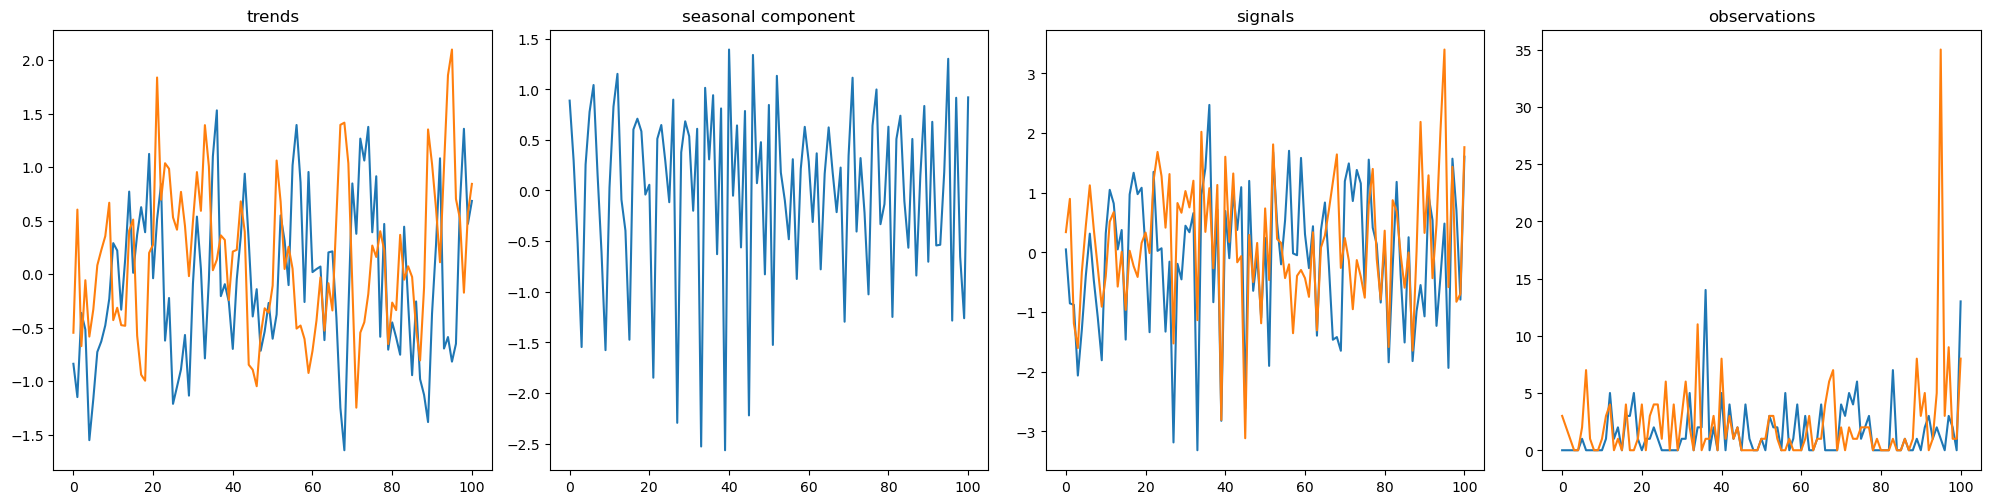

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
fig.tight_layout()

ax1.set_title("trends")
ax2.set_title("seasonal component")
ax3.set_title("signals")
ax4.set_title("observations")

ax1.plot(X[:,:2])
ax2.plot(X[:,2])
ax3.plot(vmap(jnp.matmul, (0, 0))(model.B, X))
ax4.plot(Y)

plt.show()

Notice that the observations are now integer valued.

## joint density

To evaluate the joint density we use the same approach as described in [00_glssm#Joint Density], replacing the observation density with the LCSSM one.

In [ ]:
#| export
def log_probs_y(
    x: Float[Array, "n+1 m"],  # states
    y: Float[Array, "n+1 p"],  # observations
    B: Float[Array, "n+1 p m"],  # signal matrices
    dist,  # observation distribution
    xi, # observation parameters
):
    s = (B @ x[:,:,None])[:,:,0]
    return dist(s, xi).log_prob(y).sum(axis=1)

def log_prob(
    x: Float[Array, "n+1 m"],  # states
    y: Float[Array, "n+1 p"],  # observations
    model: PGSSM
):
    x0, A, Sigma, B, dist, xi = model
    px = log_probs_x(x, GLSSMState(x0, A, Sigma)).sum()
    py = log_probs_y(x, y, B, dist, xi).sum()
    return px + py

In [ ]:
log_prob(X, Y, model)

Array(nan, dtype=float32)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()